# Radio flux density estimation of J1427-4206 @ 8GHz


### Please note:

The data you will be processing in this and other tutorials is located in the "data" folder. In there you will
find fits files for your calibrator [Hydra A](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NAME%20HYDRA%20A)
and your target source [J1427-4206](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=PKS+1424-418&submit=SIMBAD+search) at 2 GHz, 5 GHz, 8 GHz and 12 GHz frequencies. **For this exercize we will be working on
8GHz data for our target source**.

All the files you will need for the tutorial can be found at this [Github repository](https://github.com/Pfesi/AVN2019). **You need to download the file and work from that directory**. i.e. "cd into that directory"

Listed below are the steps we are going to follow to calibrate our source and estimate the flux density

# <a name="top"></a>Task list:

1. [Locate and open the observation file](#section1)
2. [Examine the fits file](#section2)
3. [Extract the drift scan data](#section3)
4. [Measure the antenna temperature](#section4)
 * 4.1 [Convert counts to units of Kelvin](#section4.1)
 * 4.2 [Fit a baseline to remove systemic contributions](#section4.2)
 * 4.3 [Fit beam to get antenna temperature](#section4.3)
 * 4.4 [Amplitude correction](#section4.4)
5. [Calculate the flux density](#section5)
6. [Got to home page](AVN_2018_Drift_scan_continuum_tutorial.ipynb)

# 1. <a name="section1">Locate and open the observation file</a> 
[back to top](#top)

Select an observation to work on and open the fits file

* The Python standard library has a [pyfits package](http://docs.astropy.org/en/stable/io/fits/index.html) we use for reading and writing FITS files and manipulating their contents. Fits files store information about a source observation in what it calls header data units (HDUs). We are going to load the package in order to begin processing our preferred file. You can read up on all the other interesting file manipulation methods by clicking on the link above.



In [1]:
import astropy.io.fits as pyfits

# Get the path name of the file you want to process
fitsfile = 'data/J1427-4206/8GHz/2013d125_21h41m04s_Cont_mike_J1427-4206.fits'
hdulist  = pyfits.open(fitsfile) 

# 2. <a name="section2">Examine the fits file</a>
[back to top](#top)

It is always a good idea to familiarize yourself with the file contents by viewing the different types of information inside your file. To get an overview of the contents we use the info() method


In [2]:
hdulist.info()

Filename: data/J1427-4206/8GHz/2013d125_21h41m04s_Cont_mike_J1427-4206.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   ()      
  1  03.5D         1 BinTableHDU     61   1R x 13C   [1D, 1D, 1D, 8A, 1D, 7A, 1D, 25A, 1D, 1D, 26A, 1D, 1D]   
  2  Scan_0_HPNZ_CAL    1 BinTableHDU    107   128R x 23C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  3  Scan_1_HPNZ    1 BinTableHDU     95   2260R x 23C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  4  Scan_2_ZC     1 BinTableHDU     95   2260R x 23C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  5  Scan_3_HPSZ    1 BinTableHDU     95   2260R x 23C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  6  Chart         1 BinTableHDU     40   8679R x 3C   [1D, 1D, 1D]   


The info() method gives us a list of all the HDUs in this file. 

* The first header data unit (HDU) contains information on the  observation.  
* The second one has information on the 2.5 cm (i.e. 12 GHz) feed system. This data is not necessarily up to date, so we generally disregard it. 
* The third unit has the noise diode firing, used to convert from raw counts to Kelvins. 
* The next three binary tables are the drift scans themselves, starting at the north offset position.
* The last HDU contains more information about the observation.

To view the content inside an HDU we use indexes. For example, to view the PRIMARY HDU, we use index 0.


In [3]:
hdulist[0].header

# You can play around with changing the indeces to see what 
# other information is stored in the other HDUs

SIMPLE  =                    T                                                  
BITPIX  =                    8                                                  
NAXIS   =                    0                                                  
EXTEND  =                    T                                                  
DATE    = '2013-05-05T21:41:04' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
COMMENT information about the object, from scheduler task                       
OBJECT  = 'J1427-4206'         / Name of object                                 
LONGITUD=     216.984583333333 / Longitude of object                            
LATITUDE=    -42.1053888888889 / Latitude of object                             
COORDSYS= 'EQUATORIAL'         / Input coordinate system                        
EQUINOX =                2000. / Input coordinate equinox                       
RADECSYS= 'ICRS    '           / Input reference frame                          
COMMENT information about th

# 3. <a name="section3">Extract the drift scan data</a>

[back to top](#top)

In [4]:
drift1 = hdulist[3] #HPN
drift2 = hdulist[4] #ON
drift3 = hdulist[5] #HPS

Lets view the drift1 HDU to see the file contents

In [5]:
drift1.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  184 / width of table in bytes                        
NAXIS2  =                 2260 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   23 / number of fields in each row                   
EXTNAME = 'Scan_1_HPNZ'        / name of this binary table extension            
FRONTEND= '03.5D   '           / Frontend ID                                    
CENTFREQ=                8280. / [MHz] Backend centre frequency                 
BANDWDTH=                 400. / [MHz] Bandwidth of backend                     
SCANTYPE= 'Drift   '        

Most of the fields are actually just the position in different formats. We are interested in the output signal '**Count1**' and '**Count2**'.  

# 4. <a name="section4">Measure the antenna temperature</a>
[back to top](#top)

## 4.1 <a name="section4.1">Convert counts to units of Kelvin </a>
[back to top](#top)

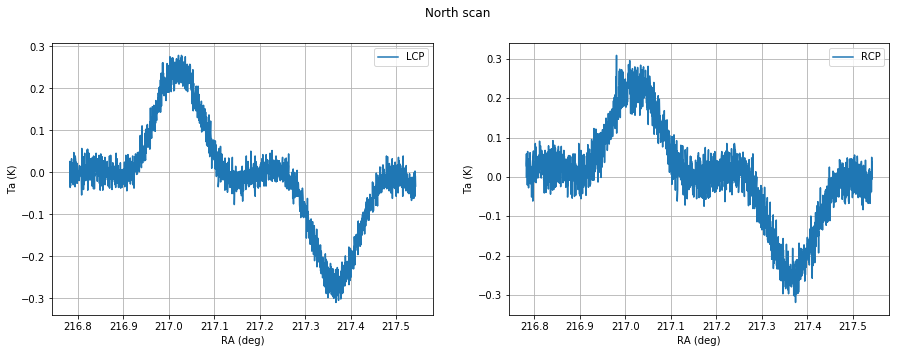

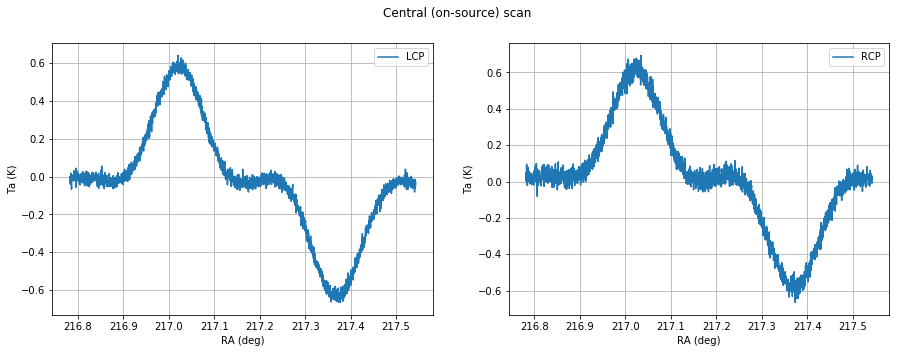

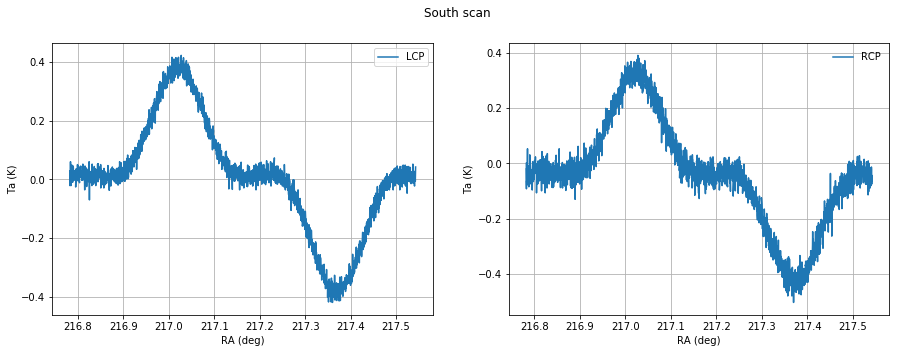

In [6]:
#Import plotting libraries
import matplotlib.pyplot as plt

#display figures inline 
%matplotlib inline  

# Get the noise diode calibration HDU
noise_cal = hdulist[2]

# Construct an array for the x-axis in terms of right ascension
ra = drift1.data['RA_J2000']

count_K1 = noise_cal.header['HZPERK1']
count_K2 = noise_cal.header['HZPERK2']

# Get source counts and convert counts to antenna temperature
north_scan_LCP = (drift1.data['Count1']/count_K1) - ((drift1.data['Count1'])[0]/count_K1) 
north_scan_RCP = (drift1.data['Count2']/count_K2) - ((drift1.data['Count2'])[0]/count_K2)
on_scan_LCP    = (drift2.data['Count1']/count_K1) - ((drift2.data['Count1'])[0]/count_K1)
on_scan_RCP    = (drift2.data['Count2']/count_K2) - ((drift2.data['Count2'])[0]/count_K2)
south_scan_LCP = (drift3.data['Count1']/count_K1) - ((drift3.data['Count1'])[0]/count_K1)
south_scan_RCP = (drift3.data['Count2']/count_K2) - ((drift3.data['Count2'])[0]/count_K2)
            
# Plot the data

# HPN 
plt.figure(figsize=[15,5])
plt.suptitle('North scan')

ax = plt.subplot(121)
plt.grid()
plt.plot(ra, north_scan_LCP, label = 'LCP')
plt.xlabel('RA (deg)')
plt.ylabel('Ta (K)')
plt.legend()
lim = plt.axis('tight')

ax = plt.subplot(122)
plt.grid()
plt.plot(ra, north_scan_RCP, label = 'RCP')
plt.xlabel('RA (deg)')
plt.ylabel('Ta (K)')
plt.legend()
lim = plt.axis('tight')

# ON
plt.figure(figsize=[15,5])
plt.suptitle('Central (on-source) scan')

ax = plt.subplot(121)
plt.grid()
plt.plot(ra, on_scan_LCP, label = 'LCP')
plt.xlabel('RA (deg)')
plt.ylabel('Ta (K)')
plt.legend()
lim = plt.axis('tight')

ax = plt.subplot(122)
plt.grid()
plt.plot(ra, on_scan_RCP, label = 'RCP')
plt.xlabel('RA (deg)')
plt.ylabel('Ta (K)')
plt.legend()
lim = plt.axis('tight')

# HPS
plt.figure(figsize=[15,5])
plt.suptitle('South scan')

ax = plt.subplot(121)
plt.grid()
plt.plot(ra, south_scan_LCP, label = 'LCP')
plt.xlabel('RA (deg)')
plt.ylabel('Ta (K)')
plt.legend()
lim = plt.axis('tight')

ax = plt.subplot(122)
plt.plot(ra, south_scan_RCP, label = 'RCP')
plt.xlabel('RA (deg)')
plt.ylabel('Ta (K)')
plt.legend(frameon=False)
plt.grid()
lim = plt.axis('tight')


## 4.2 <a name="section4.2">Fit a baseline to remove systemic contributions</a>
[back to top](#top)

We are only interested in the temperature contributed by the source, so we want to subract off the system temperature contribution.  We see that the baseline level changes through during the scan.

What do we fit then?  This is a fairly strong source, we can clealy see the antenna beam pattern.  Looking carefully we can see a deflection point at the base of the beam.  This is the first null of the beam. At these points we will not be receiving any power from the source.


Locate the section you want to use for your fit. We are going to write a few methods to help us process the location selection for our fit

In [7]:
def getBasePts(x, y,len_scan,x1,x2,x3,x4): 
    '''
        Get baseline points. Select points along the driftscan where you will fit
        your baseline.
    '''

    xbleft = x[x1:x2]
    ybleft = y[x1:x2]
    xbright= x[len_scan-x3:len_scan-x4]
    ybright= y[len_scan-x3:len_scan-x4]

    left_base_pts = list(xbleft) + list(xbright)
    right_base_pts = list(ybleft) + list(ybright)

    return left_base_pts, right_base_pts 


Fit the baseline and plot your data

Y = mx + c
Fit = -0.00x + 0, rms error = 0.019
Fit = -0.00x + 0, rms error = 0.030
Fit = -0.04x + 8, rms error = 0.021
Fit = -0.05x + 9, rms error = 0.028
Fit = -0.03x + 5, rms error = 0.020
Fit = -0.02x + 3, rms error = 0.029


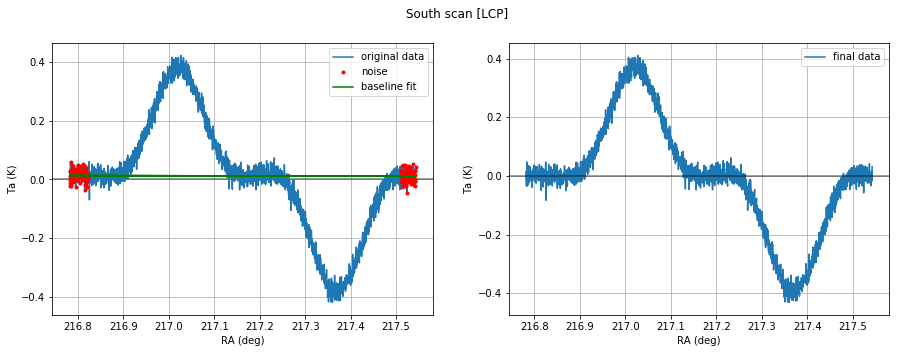

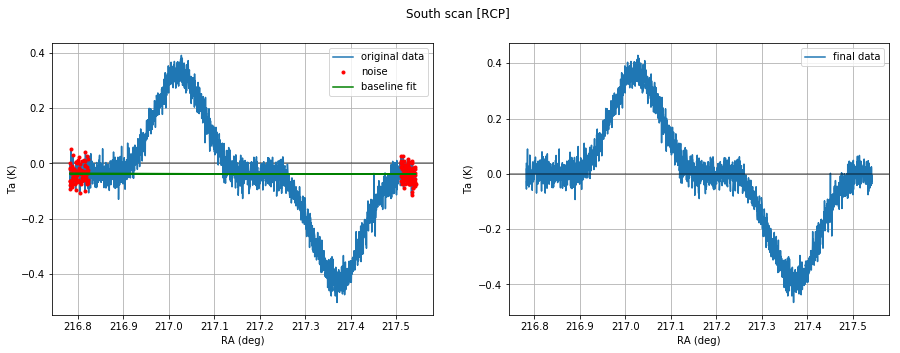

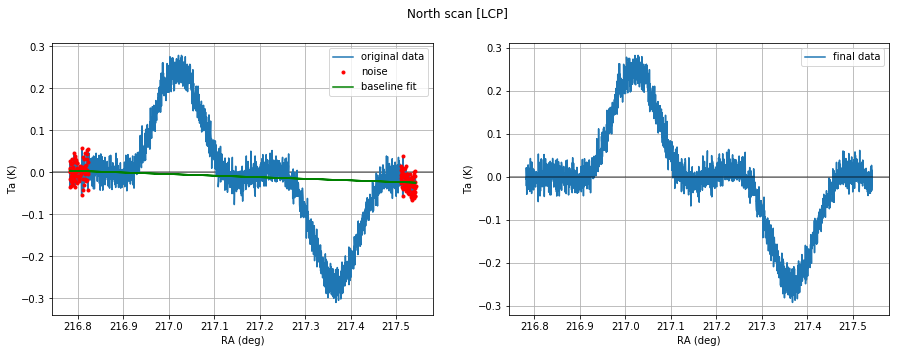

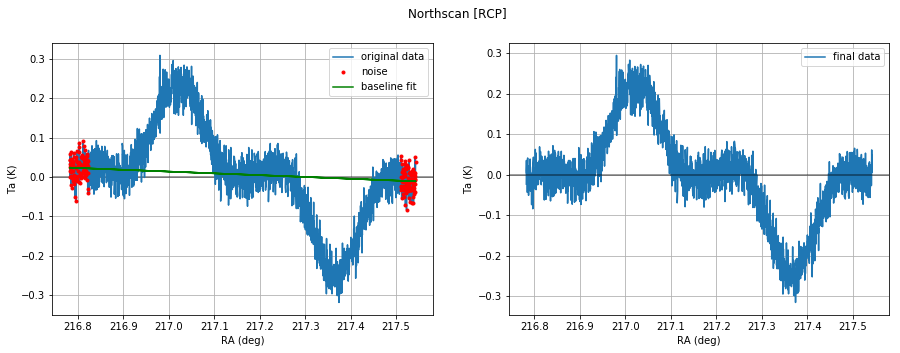

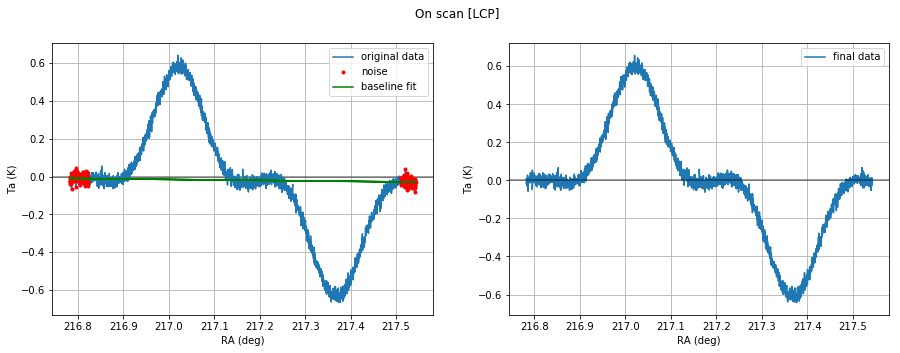

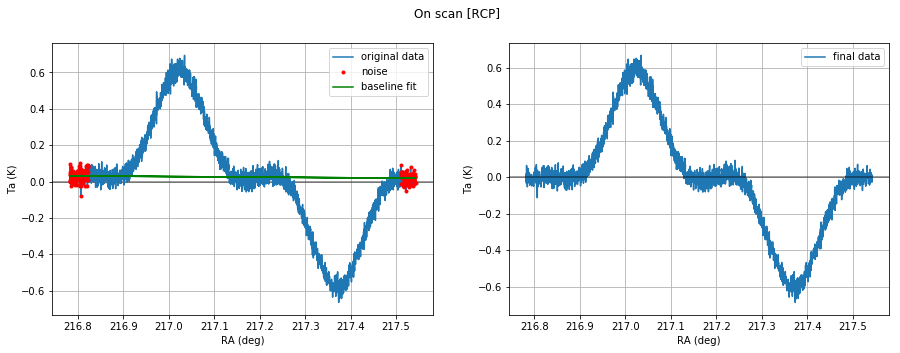

In [8]:
import numpy as np

def fitBasePts(x_base_pts,y_base_pts, x, y):
    """Fit the data to remove systematic contributions.
    """
        
    base_fit_coeffs = np.polyfit(x_base_pts, y_base_pts, 1)
    base_fit_line = np.polyval(base_fit_coeffs,x_base_pts)   
    data_fit = np.polyval(base_fit_coeffs, x)
    data_fit = y - data_fit
    
    res,rms = residual(y_base_pts,base_fit_line)
   
    print ("Fit = %.2fx + %d, rms error = %.3f" %(base_fit_coeffs[0], base_fit_coeffs[1],rms))
    
    return data_fit, base_fit_line
    
# Get the residual and rms to estimate the errors in the fit
def residual(model, data): 
    
    from sklearn.metrics import mean_squared_error
    """
        Calculate the residual between the model and the data.
    """

    res = np.array(model - data)
    rms = np.sqrt(mean_squared_error(data,model))

    return res, rms

def fitBaselineAndPlot(x,y,title,x1,x2,x3,x4,len_scan):
    """
        Fit the baseline and plot your data
    """


    xb,yb = getBasePts(x,y,len_scan,x1,x2,x3,x4)
    
    # Fit the baseline points
    fit, base_fit_line = fitBasePts(xb,yb, x, y)

    # plot the data
    plt.figure(figsize=[15,5])
    plt.suptitle(title)

    ax = plt.subplot(121)
    plt.axhline(y=0, color='k', alpha= 0.5)
    l1,= plt.plot(x,y, label = 'original data')
    l2,= plt.plot(xb,yb,'r.', label = 'noise')
    plt.plot(xb,base_fit_line, 'g', label = "baseline fit")
    plt.xlabel('RA (deg)')
    plt.ylabel('Ta (K)')
    plt.legend()
    plt.grid()
    lim = plt.axis('tight')

    ax = plt.subplot(122)
    l1,= plt.plot(x,fit, label = 'final data')
    plt.xlabel('RA (deg)')
    plt.ylabel('Ta (K)')
    plt.axhline(y=0, color='k', alpha= 0.5)
    plt.legend()
    plt.grid()
    lim = plt.axis('tight')
    
    return fit

# Get the length of the scans
len_scan = len(ra)

# Set the baseline points, default is 100 points on each side
# You can change the x1-x4 values to adjust the location of
# your baseline fit.

 # YOU CAN MODIFY THESE VALUES
x1 = 0
x2 = 100
x3 = 100
x4 = 0
    
print ("Y = mx + c")
# Fit and plot 

# *NB* If you want to change individual baseline points, do it here.
slcp  = fitBaselineAndPlot(ra, south_scan_LCP, 'South scan [LCP]',x1,x2,x3,x4,len_scan)
srcp  = fitBaselineAndPlot(ra, south_scan_RCP, 'South scan [RCP]',x1,x2,x3,x4,len_scan)
nlcp  = fitBaselineAndPlot(ra, north_scan_LCP, 'North scan [LCP]',x1,x2,x3,x4,len_scan)
nrcp  = fitBaselineAndPlot(ra, north_scan_RCP, 'Northscan [RCP]',x1,x2,x3,x4,len_scan)
onlcp = fitBaselineAndPlot(ra, on_scan_LCP, 'On scan [LCP]',x1,x2,x3,x4,len_scan)
onrcp = fitBaselineAndPlot(ra, on_scan_RCP, 'On scan [RCP]',x1,x2,x3,x4,len_scan)



## 4.3 <a name="section4.3">Fit beam to get antenna temperature</a>
[back to top](#top)


We are now going to fit the top of the beam to fit the 
antenna temperature. We will use a 2nd order polynomial fit
at the top of the peak. 

In [10]:
# Get location of peak
def getAPeakPts(drift, percentage):
    """Get locations of scan peak where we are going to fit 
       We will be fitting the top 40% of our scan.
    """
    peak_frac = float((100.0 - percentage)/100.0)
    peak_max = max(drift)
    peak_pts = np.where(drift > peak_frac * peak_max)[0]
    return peak_pts

def getBPeakPts(drift, percentage):
    """Get locations of scan peak where we are going to fit 
       We will be fitting the top 40% of our scan.
    """
    peak_frac = float((100.0 - percentage)/100.0)
    peak_min = min(drift)
    peak_pts = np.where(drift < peak_frac * peak_min)[0]
    return peak_pts

# Fit the peak
def fitPeak(peak_pts, x, y):
    """Fit the peak and estimate errors.
    """

    peakfitcoeffs = np.polyfit(x[peak_pts], y[peak_pts], 2)
    peakfitline = np.polyval(peakfitcoeffs,x[peak_pts])
    res, rms = residual(peakfitline, y[peak_pts])

    return peakfitline,rms, x[peak_pts], y[peak_pts]

# Get peak points

# YOU CAN MODIFY THIS VALUE
peak_percentage = 40 # Change the percentage of the peak data you want to fit.

# Get peak points, Abeam
Apeak_pts_slcp  = getAPeakPts(slcp, peak_percentage)
Apeak_pts_srcp  = getAPeakPts(srcp, peak_percentage)
Apeak_pts_nlcp  = getAPeakPts(nlcp, peak_percentage)
Apeak_pts_nrcp  = getAPeakPts(nrcp, peak_percentage)
Apeak_pts_onlcp = getAPeakPts(onlcp, peak_percentage)
Apeak_pts_onrcp = getAPeakPts(onrcp, peak_percentage)

# Get peak points, Bbeam
Bpeak_pts_slcp  = getBPeakPts(slcp, peak_percentage)
Bpeak_pts_srcp  = getBPeakPts(srcp, peak_percentage)
Bpeak_pts_nlcp  = getBPeakPts(nlcp, peak_percentage)
Bpeak_pts_nrcp  = getBPeakPts(nrcp, peak_percentage)
Bpeak_pts_onlcp = getBPeakPts(onlcp, peak_percentage)
Bpeak_pts_onrcp = getBPeakPts(onrcp, peak_percentage)

# Fit the peaks
Afitpsl, Aslrms, Axpslcp, Aypslcp   = fitPeak(Apeak_pts_slcp, ra, slcp)
Afitpsr, Asrrms, Axpsrcp, Aypsrcp   = fitPeak(Apeak_pts_srcp, ra, srcp)
Afitpnl, Anlrms, Axpnlcp, Aypnlcp   = fitPeak(Apeak_pts_nlcp, ra, nlcp)
Afitpnr, Anrrms, Axpnrcp, Aypnrcp   = fitPeak(Apeak_pts_nrcp, ra, nrcp)
Afitponl, Aonlrms, Axpolcp, Aypolcp = fitPeak(Apeak_pts_onlcp, ra, onlcp)
Afitponr, Aonrrms, Axporcp, Ayporcp = fitPeak(Apeak_pts_onrcp, ra, onrcp)

Bfitpsl, Bslrms, Bxpslcp, Bypslcp   = fitPeak(Bpeak_pts_slcp, ra, slcp)
Bfitpsr, Bsrrms, Bxpsrcp, Bypsrcp   = fitPeak(Bpeak_pts_srcp, ra, srcp)
Bfitpnl, Bnlrms, Bxpnlcp, Bypnlcp   = fitPeak(Bpeak_pts_nlcp, ra, nlcp)
Bfitpnr, Bnrrms, Bxpnrcp, Bypnrcp   = fitPeak(Bpeak_pts_nrcp, ra, nrcp)
Bfitponl, Bonlrms, Bxpolcp, Bypolcp = fitPeak(Bpeak_pts_onlcp, ra, onlcp)
Bfitponr, Bonrrms, Bxporcp, Byporcp = fitPeak(Bpeak_pts_onrcp, ra, onrcp)

# Print out the ANTENNA TEMPERATURES
print ('Ta_ASLCP = %.3f +- %.3f [K], Ta_BSLCP = %.3f +- %.3f [K]' %(max(Afitpsl), Aslrms, min(Bfitpsl), Bslrms))
print ('Ta_ASRCP = %.3f +- %.3f [K], Ta_BSRCP = %.3f +- %.3f [K]' %(max(Afitpsr), Asrrms, min(Bfitpsr), Bsrrms))
print ('Ta_ANLCP = %.3f +- %.3f [K], Ta_BNLCP = %.3f +- %.3f [K]' %(max(Afitpnl), Anlrms, min(Bfitpnl), Bnlrms))
print ('Ta_ANRCP = %.3f +- %.3f K], Ta_BNRCP = %.3f +- %.3f K]' %(max(Afitpnr), Anrrms, min(Bfitpnr), Bnrrms))
print ('Ta_AONLCP = %.3f +- %.3f [K], Ta_BONLCP = %.3f +- %.3f [K]' %(max(Afitponl), Aonlrms, min(Bfitponl), Bonlrms))
print ('Ta_AONRCP = %.3f +- %.3f [K], Ta_BONRCP = %.3f +- %.3f [K]' %(max(Afitponr), Aonrrms, min(Bfitponr), Bonrrms))



Ta_ASLCP = 0.365 +- 0.019 [K], Ta_BSLCP = -0.387 +- 0.019 [K]
Ta_ASRCP = 0.364 +- 0.026 [K], Ta_BSRCP = -0.382 +- 0.028 [K]
Ta_ANLCP = 0.247 +- 0.021 [K], Ta_BNLCP = -0.244 +- 0.020 [K]
Ta_ANRCP = 0.225 +- 0.024 K], Ta_BNRCP = -0.246 +- 0.022 K]
Ta_AONLCP = 0.593 +- 0.020 [K], Ta_BONLCP = -0.605 +- 0.021 [K]
Ta_AONRCP = 0.582 +- 0.035 [K], Ta_BONRCP = -0.598 +- 0.031 [K]


Plot the fits

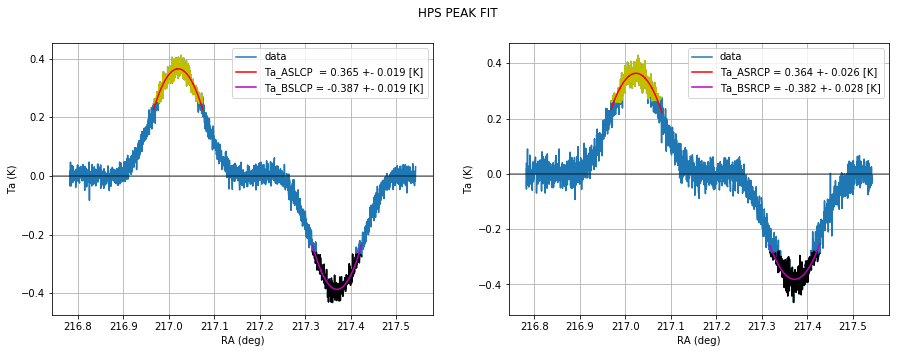

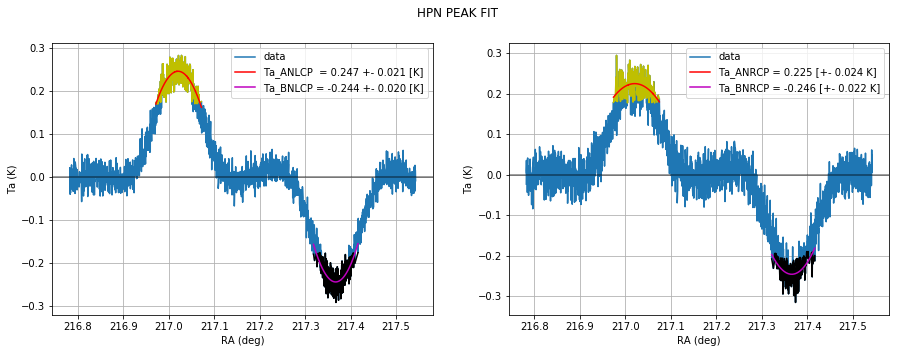

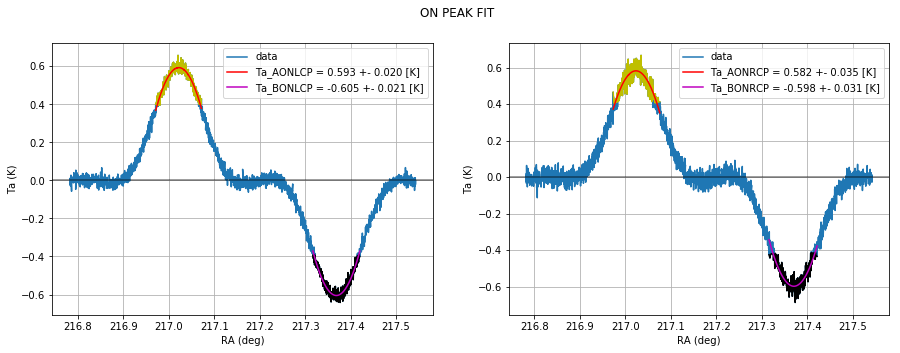

In [11]:
def plotFit(ra, drift1, title, peak_pts1,fit1,drift2, peak_pts2,fit2, peak_pts3,fit3, peak_pts4,fit4, lab1,lab2,lab3,lab4,Axp1, Ayp1,Bxp1, Byp1,Axp2, Ayp2,Bxp2, Byp2):
    
    # plot the data
    plt.figure(figsize=[15,5])
    plt.suptitle(title)
    
    ax = plt.subplot(121)
    l1,= plt.plot(ra,drift1, label = 'data')
    plt.plot(Axp1,Ayp1,'y')
    plt.plot(Bxp1,Byp1,'k')
    l3,= plt.plot(ra[peak_pts1],fit1,'r', label=lab1)
    l4,= plt.plot(ra[peak_pts2],fit2,'m', label=lab2)    
    plt.xlabel('RA (deg)')
    plt.ylabel('Ta (K)')
    plt.legend()
    plt.axhline(y=0, color='k', alpha= 0.5)
    plt.grid()
    lim = plt.axis('tight')

    ax = plt.subplot(122)
    l1,= plt.plot(ra,drift2, label = 'data')
    plt.plot(Axp2,Ayp2,'y')
    plt.plot(Bxp2,Byp2,'k')
    l3,= plt.plot(ra[peak_pts3],fit3, 'r',label = lab3)
    l4,= plt.plot(ra[peak_pts4],fit4, 'm', label = lab4)    
    plt.xlabel('RA (deg)')
    plt.ylabel('Ta (K)')
    plt.axhline(y=0, color='k', alpha= 0.5)
    plt.legend()
    plt.grid()
    lim = plt.axis('tight')

plotFit(ra,slcp,'HPS PEAK FIT',Apeak_pts_slcp, Afitpsl,  srcp, Bpeak_pts_slcp, Bfitpsl, Apeak_pts_srcp, Afitpsr, Bpeak_pts_srcp, Bfitpsr, 'Ta_ASLCP  = %.3f +- %.3f [K]' %(max(Afitpsl), Aslrms),  'Ta_BSLCP = %.3f +- %.3f [K]' %(min(Bfitpsl), Bslrms),  'Ta_ASRCP = %.3f +- %.3f [K]' %(max(Afitpsr), Asrrms), 'Ta_BSRCP = %.3f +- %.3f [K]' %(min(Bfitpsr), Bsrrms),  Axpslcp, Aypslcp,Bxpslcp, Bypslcp,Axpsrcp, Aypsrcp,Bxpsrcp, Bypsrcp)
plotFit(ra,nlcp,'HPN PEAK FIT',Apeak_pts_nlcp, Afitpnl,  nrcp, Bpeak_pts_nlcp, Bfitpnl, Apeak_pts_nrcp, Afitpnr, Bpeak_pts_nrcp, Bfitpnr, 'Ta_ANLCP  = %.3f +- %.3f [K]' %(max(Afitpnl), Anlrms),  'Ta_BNLCP = %.3f +- %.3f [K]' %(min(Bfitpnl), Bnlrms),  'Ta_ANRCP = %.3f [+- %.3f K]' %(max(Afitpnr), Anrrms), 'Ta_BNRCP = %.3f [+- %.3f K]' %(min(Bfitpnr), Bnrrms),  Axpnlcp, Aypnlcp,Bxpnlcp, Bypnlcp,Axpnrcp, Aypnrcp,Bxpnrcp, Bypnrcp)
plotFit(ra,onlcp,'ON PEAK FIT',Apeak_pts_onlcp,Afitponl, onrcp,Bpeak_pts_onlcp,Bfitponl,Apeak_pts_onrcp,Afitponr,Bpeak_pts_onrcp,Bfitponr,'Ta_AONLCP = %.3f +- %.3f [K]' %(max(Afitponl),Aonlrms), 'Ta_BONLCP = %.3f +- %.3f [K]'%(min(Bfitponl),Bonlrms),'Ta_AONRCP = %.3f +- %.3f [K]' %(max(Afitponr),Aonrrms),'Ta_BONRCP = %.3f +- %.3f [K]'%(min(Bfitponr),Bonrrms), Axpolcp,Aypolcp,Bxpolcp, Bypolcp,Axporcp, Ayporcp,Bxporcp, Byporcp)



## 4.4 <a name="section4.4">Amplitude correction</a>
[back to top](#top)

As you can see our pointing is off and we need to correct for that

In [12]:
def correctAmp(hpn,errhpn,hps,errhps,on,erron):

    ''' Calculate the pointing correction

        Tcorr = Ton x exp[((ln(Thps) - ln(Thpn))**2)/(16*ln(2))]

        Tcorr = Ton x pc

        term1 = ((ln(Thps) - ln(Thpn))**2)
        term2 = 16*ln(2)
        term3 = term1/term2
        pc = exp[term3]
    '''

    # Calculate the pointing correction
    term1 = (np.log(abs(hps)) - np.log(abs(hpn)))**2
    term2 = 16*np.log(2)
    term3 = term1/term2
    pc = np.exp(term3)
            
    # Calculate the corrected antenna temperature
    Tcorr = abs(on * pc)

    # Calculate the error in the pointing correction
    if hps < 0.0:
        pf1 = pc * 2.0 * term3 * (1.0/hps)
    else:
        pf1 = pc * 2.0 * term3 * (1.0/abs(hps))
                                
    if hpn < 0.0:
        pf2 = pc * 2.0 * term3 * (-1.0/hpn)
    else:
        pf2 = pc * 2.0 * term3 * (1.0/abs(hpn))
            
    pcerr = np.sqrt((errhpn**2) + (errhps**2)) # err in pc

    # Calculate the error in the corrected antenna temperature
    Tcorrerr = np.sqrt((erron/on)**2 + (pcerr/pc)**2)*Tcorr
            
    return pc, pcerr, Tcorr, Tcorrerr


Calculate the corrected amplitude



In [14]:
# Calculate Pointing correction
Apcl, Apcerrl, ATcorrl, ATcorerrl = correctAmp(max(Afitpnl), Anlrms, max(Afitpsl), Aslrms, max(Afitponl), Aonlrms)
Bpcl, Bpcerrl, BTcorrl, BTcorerrl = correctAmp(min(Bfitpnl), Bnlrms, min(Bfitpsl), Bslrms, min(Bfitponl), Bonlrms)

Apcr, Apcerrr, ATcorrr, ATcorerrr = correctAmp(max(Afitpnr), Anrrms, max(Afitpsr), Asrrms, max(Afitponr), Aonrrms)
Bpcr, Bpcerrr, BTcorrr, BTcorerrr = correctAmp(min(Bfitpnr), Bnrrms, min(Bfitpsr), Bsrrms, min(Bfitponr), Bonrrms)

print ('Ta_ALCP corr = %.4f +- %.4f [K]' %(max(Afitponl), Aonlrms))
print ('Ta_BLCP corr = %.4f +- %.4f [K]' %(min(Bfitponl), Bonlrms))
print ('Ta_ARCP corr = %.4f +- %.4f [K]' %(max(Afitponr), Aonrrms)) 
print ('Ta_BRCP corr = %.4f +- %.4f [K]\n' %(min(Bfitponr), Bonrrms))

print ('Amplitude correction factor due to pointing error in A BEAM LCP = %.4f +- %f [K] ' %(Apcl, Apcerrl))
print ('Amplitude correction factor due to pointing error in B BEAM LCP = %.4f +- %f [K] ' %(Bpcl, Bpcerrl))
print ('Amplitude correction factor due to pointing error in A BEAM RCP = %.4f +- %f [K] ' %(Apcr, Apcerrr))
print ('Amplitude correction factor due to pointing error in B BEAM RCP = %.4f +- %f [K]\n' %(Bpcr, Bpcerrr))

print ('Ta_ALCP corr = %.4f +- %.4f [K]' %(ATcorrl, ATcorerrl))
print ('Ta_BLCP corr = %.4f +- %.4f [K]' %(BTcorrl, BTcorerrl))
print ('Ta_ARCP corr = %.4f +- %.4f [K]' %(ATcorrr, ATcorerrr))
print ('Ta_BRCP corr = %.4f +- %.4f [K]' %(BTcorrr, BTcorerrr))

Ta_ALCP corr = 0.5929 +- 0.0202 [K]
Ta_BLCP corr = -0.6051 +- 0.0206 [K]
Ta_ARCP corr = 0.5823 +- 0.0348 [K]
Ta_BRCP corr = -0.5975 +- 0.0311 [K]

Amplitude correction factor due to pointing error in A BEAM LCP = 1.0140 +- 0.028342 [K] 
Amplitude correction factor due to pointing error in B BEAM LCP = 1.0194 +- 0.027679 [K] 
Amplitude correction factor due to pointing error in A BEAM RCP = 1.0211 +- 0.035429 [K] 
Amplitude correction factor due to pointing error in B BEAM RCP = 1.0175 +- 0.035724 [K]

Ta_ALCP corr = 0.6012 +- 0.0265 [K]
Ta_BLCP corr = 0.6168 +- 0.0269 [K]
Ta_ARCP corr = 0.5946 +- 0.0411 [K]
Ta_BRCP corr = 0.6080 +- 0.0382 [K]


# 5. <a name="section5">Calculate the Flux density</a>
[back to top](#top)

In [15]:
def fluxDensity(pss,errpss,ta,errta):

    '''Calculate the source flux density'''
    
    flux = pss*ta
    errflux = np.sqrt((errpss/pss)**2 + (errta/ta)**2) * flux

    return flux, errflux

def totfluxDensity(Afluxlcp,Aerrfluxlcp,Bfluxlcp,Berrfluxlcp,Afluxrcp,Aerrfluxrcp,Bfluxrcp,Berrfluxrcp):

    '''Calculate the source flux density'''
    
    flux = ((Afluxlcp + Bfluxlcp + Afluxrcp + Bfluxrcp)/4.0)*2.0
    errflux = np.sqrt((Aerrfluxlcp)**2 + (Berrfluxlcp)**2 + (Aerrfluxrcp)**2 + (Berrfluxrcp)**2 )

    return flux, errflux

In [16]:
# Calculate flux density

#PSS @ 5 GHz

Apsslcp = 6.052
Aerrpsslcp = 0.231
Bpsslcp = 6.025
Berrpsslcp = 0.225
Apssrcp = 6.504
Aerrpssrcp =  0.508
Bpssrcp = 6.291
Berrpssrcp = 0.361


#Flux
Afluxlcp, Aerrfluxlcp = fluxDensity(Apsslcp,Aerrpsslcp,ATcorrl,ATcorerrl)
Bfluxlcp, Berrfluxlcp = fluxDensity(Bpsslcp,Berrpsslcp,BTcorrl,BTcorerrl)
Afluxrcp, Aerrfluxrcp = fluxDensity(Apssrcp,Aerrpssrcp,ATcorrr,ATcorerrr)
Bfluxrcp, Berrfluxrcp = fluxDensity(Bpssrcp,Berrpssrcp,BTcorrr,BTcorerrr)


totflux, errtotflux = totfluxDensity(Afluxlcp, Aerrfluxlcp,Bfluxlcp, Berrfluxlcp,Afluxrcp, Aerrfluxrcp,Bfluxrcp, Berrfluxrcp)

print ('AFlux_LCP corr = %.3f +- %.3f [K]' %(Afluxlcp, Aerrfluxlcp))
print ('BFlux_LCP corr = %.3f +- %.3f [K]' %(Bfluxlcp, Berrfluxlcp))
print ('AFlux_RCP corr = %.3f +- %.3f [K]' %(Afluxrcp, Aerrfluxrcp))
print ('BFlux_RCP corr = %.3f +- %.3f [K]' %(Bfluxrcp, Berrfluxrcp))
print ('Total_flux = %.3f +- %.3f [K]' %(totflux, errtotflux))




AFlux_LCP corr = 3.638 +- 0.212 [K]
BFlux_LCP corr = 3.716 +- 0.213 [K]
AFlux_RCP corr = 3.867 +- 0.403 [K]
BFlux_RCP corr = 3.825 +- 0.325 [K]
Total_flux = 7.523 +- 0.599 [K]


Link to [AVN](AVN_2018_Drift_scan_continuum_tutorial.ipynb) notebook 